In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sb
import pandas as pd
from models import Classifier
from utils import calculate_accuracy, train

### Dataloader

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225] ,inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225] ,inplace=True)
])
subset_ratio = 0.2
orig_dataset = ImageFolder(root='./dataset/chest_xray/train/', transform = train_transform)
n = len(orig_dataset)  # total number of examples
print(f"Total Dataset size: {n}")

indices = list(range(n))
# randomly shuffle the indices
np.random.shuffle(indices)

# calculate the split index for the subset
split = int(np.floor(subset_ratio * n))

val_sampler = SubsetRandomSampler(indices[:split])
train_sampler = SubsetRandomSampler(indices[split:])
test_dataset = ImageFolder(root='./dataset/chest_xray/test/', transform = test_transform)

train_dataloader = DataLoader(orig_dataset, batch_size = 64, sampler=train_sampler)
val_dataloader = DataLoader(orig_dataset, batch_size = 16, sampler=val_sampler)
test_dataloader = DataLoader(test_dataset, shuffle = True, batch_size = 1)

### Model training

In [ ]:
model = Classifier()
# optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.0001
optim = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=1e-3)
model.to(device)
print(device)

In [ ]:
train_loss, val_f1, Val_accuracy = train(model, optim, loss_fn, train_dataloader, val_dataloader, epochs = 1, early_stop_threshold=5, model_file_name="models/cnn_model.pdh")

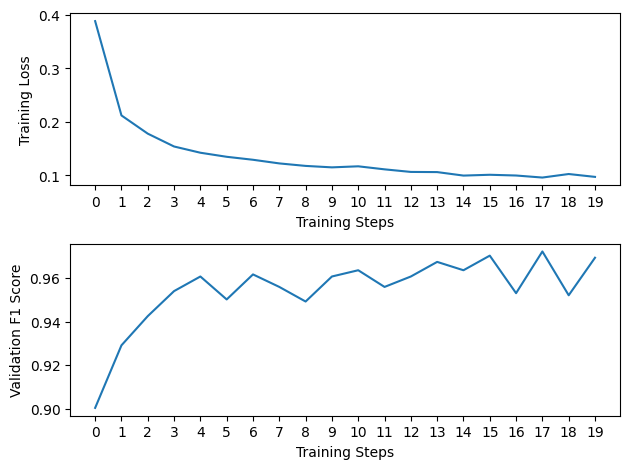

In [7]:
plt.subplot(2, 1, 1)
plt.xticks(range(len(train_loss)))
plt.plot(train_loss)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")


plt.subplot(2, 1, 2)
plt.plot(val_f1)

plt.xlabel("Training Steps")
plt.ylabel("Validation F1 Score")
plt.xticks(range(len(val_f1)))

plt.tight_layout()
plt.savefig("plot_conv_net.pdf")
plt.show()

In [ ]:
# confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Pneumonia']
df_cm = pd.DataFrame(cf_matrix, index = class_names, columns = class_names)
sb.heatmap(df_cm, annot=True, fmt="d")
plt.savefig("conv_net_confusion_matrix.pdf")
plt.show()

### Class Activation Map

In [ ]:
data = enumerate(test_dataloader)

In [ ]:
_, (example_data, target) = data.__next__()
feature_map = model.get_feature_map(example_data.to(device))
pred = infer(model, example_data)
weights = model.fc[0].weight.data
cams = return_CAM(F.avg_pool2d(feature_map, 27), weights, pred)
heat_map = cv2.applyColorMap(cv2.resize(cams[0],(224, 224)), cv2.COLORMAP_JET)
plt.subplot(1, 3, 1)
plt.imshow(0.5*(example_data)[0].permute(1, 2, 0) + 0.5 * (heat_map / 255))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(heat_map)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow((example_data)[0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

print(pred[0])
plt.show()